In [1]:
import os

repo_dir = os.environ.get("REPO_DIR")
code_dir = os.path.join(repo_dir, "code/")
data_dir = os.path.join(repo_dir, "data/")
os.chdir(code_dir)

import matplotlib.pyplot as plt
import numpy as np
import scipy.linalg
import pickle
import sklearn 
import sys
import pandas as pd
from importlib import reload

from sklearn.model_selection import KFold
from sklearn.linear_model import Ridge
import seaborn as sns

from scipy.stats import spearmanr

import geopandas as gpd

import warnings

from mosaiks.utils.imports import *

# Key prediction functions are here
from prediction_utils import (X_matrix_to_demeaned_X, df_to_demeaned_y_vars,
make_train_pred_scatterplot as make_scatterplot, cv_solve, solver_kwargs, get_truth_preds_from_kfold_results,
                             predict_y_from_kfold_dict, generalized_demean)


import rasterio
import rasterio.mask
from rasterio import warp

# NL Downscaling validation experiment

In this notebook we will try to predict mean DMSP nightlight luminosity at the ADM2 level, using a model trained at the ADM1 level. We use only MOSAIKS daytime image features in this experiment.

This notebook requires the user to download all of the CGAZ python/pickle with population weights files from [mosaiks.org](mosaiks.org). Note that the ADM2 feature files is 3.5GB.

Current page link is here: https://siml.berkeley.edu/portal/precomputed/

## Read Data

In [2]:
## Mosiaks features generated in the featurization pipeline. Replication not available

In [3]:
mosaiks_features_direc = data_dir + "features/mosaiks_features/"

X_adm2 = pd.read_pickle(mosaiks_features_direc + "ADM_2_regions_RCF_global_dense_pop_weight=True.p")

X_adm1 = pd.read_pickle(mosaiks_features_direc + "ADM_2_regions_RCF_global_dense_aggregated_to_ADM1_pop_weight=True.p")

X_adm0 = pd.read_pickle(mosaiks_features_direc + "ADM_2_regions_RCF_global_dense_aggregated_to_ADM0_pop_weight=True.p")

In [4]:
nl_true_directory = data_dir + "nl_downscaling/nl_Ys/"

y_adm2 = pd.read_pickle( nl_true_directory + 
                       "dmsp_avg_nl_Ys_geoB_adm2.p" ).astype(float)

y_adm1 = pd.read_pickle(  nl_true_directory + 
                       "dmsp_avg_nl_Ys_geoB_adm1.p" ).astype(float) 


y_adm0 = pd.read_pickle(  nl_true_directory + 
                       "dmsp_avg_nl_Ys_geoB_adm0.p" ).astype(float)

In [5]:
# adm2_shp = gpd.read_file(data_dir + "raw/geoBoundaries/"
#                         "geoBoundariesCGAZ_ADM2.geojson")

# link_df = adm2_shp[["shapeID","shapeGroup","ADM1_shapeID"]]

path = data_dir + "int/geoBoundaries/flat_geoBoundaries_link.p"
# link_df.to_pickle(path)
link_df = pd.read_pickle(path)

link_df.rename(columns = {"ADM1_shapeID":"ADM1_shape"}, inplace=True)

## Set parameters

In [6]:
## Set up two tasks, pop weighted NL and average NL
tasks = y_adm2.columns


# Ireland has 50,000 ADM2 observations. Half the ADM2 dataset....
drop_ireland = True

extra_clip = True

recenter_on = "adm0"

### Inspect missing data

In [7]:
# There are some very small ADM1 regions that did not get assigned true NL vales

# We will drop drop these
# There are also a few obs with missing Xs
print(y_adm1.drop(y_adm1.dropna().index))
y_adm1.dropna(inplace=True)
X_adm1 = X_adm1.loc[X_adm1.index.isin(y_adm1.index)]
y_adm1 = y_adm1.loc[X_adm1.index]

                    nl_avg  nl_weighted_avg
ADM1_shape                                 
NRU-ADM1-3_0_0-B11     NaN              NaN
TUV-ADM1-3_0_0-B4      NaN              NaN


In [8]:
# There are some a number of ADM2 regions that did not get assigned true NL vales
# This is likley because they are outside the range of the raster data

# There are also a few obs with missing Xs

print(y_adm2.drop(y_adm2.dropna().index))
y_adm2.dropna(inplace=True)

X_adm2 = X_adm2.loc[X_adm2.index.isin(y_adm2.index)]
y_adm2 = y_adm2.loc[X_adm2.index]

                      nl_avg  nl_weighted_avg
shapeID                                      
NOR-ADM2-3_0_0-B383      NaN              NaN
BRN-ADM2-3_0_0-B17       NaN              NaN
BRN-ADM2-3_0_0-B18       NaN              NaN
IRL-ADM2-3_0_0-B1        NaN              NaN
IRL-ADM2-3_0_0-B8        NaN              NaN
...                      ...              ...
VNM-ADM2-3_0_0-B1373     NaN              NaN
VNM-ADM2-3_0_0-B1464     NaN              NaN
VNM-ADM2-3_0_0-B1515     NaN              NaN
VNM-ADM2-3_0_0-B1549     NaN              NaN
CHE-ADM2-3_0_0-B163      NaN              NaN

[2642 rows x 2 columns]


In [9]:

## There are 124 ADM2 polygons that have no parent ADM1 shape.
## None of these even have y values at the adm2 level

# 65 of these are associated with a Y. They must be dropped
no_parent_ids = link_df[link_df["ADM1_shape"].isnull()]["shapeID"]

no_parent_ids_with_y = no_parent_ids[no_parent_ids.isin(y_adm2.index)]

X_adm2.drop(no_parent_ids_with_y, inplace=True)
y_adm2.drop(no_parent_ids_with_y, inplace=True)

In [10]:
## There are some ADM2 NL vals that do not have a parent y value.
temp = y_adm2.merge(link_df,"left", left_index=True,right_on="shapeID")
temp = temp.merge(y_adm1, "left", left_on="ADM1_shape", right_index=True)
no_parent_y_idxs = temp[temp["nl_weighted_avg_y"].isnull()]["shapeID"]


X_adm2.drop(no_parent_y_idxs, inplace=True)
y_adm2.drop(no_parent_y_idxs, inplace=True)

In [11]:
## Set up two tasks, pop weighted NL and average NL
tasks = y_adm2.columns

In [12]:
tasks = y_adm2.columns

## Demean Xs and Ys for later use

#### Demean Xs

In [13]:
##### This step below is a bit confusing
### We demean by the mean of the observations. the X_adm0 file is population weighted
### We do not want to demean in a pop-weighted way. This matches our HDI procedure



X_adm0_not_weighted =X_matrix_to_demeaned_X(X_adm1, return_mean_frame = True)

X_adm1["shapeGroup"] = pd.Series(X_adm1.index).apply(lambda x : x[:3]).to_numpy()
X_adm1_demeaned = generalized_demean(X_adm1, X_adm0_not_weighted, "shapeGroup")

In [14]:
X_adm2.drop(columns = "shapeID", inplace=True)
X_adm2["shapeGroup"] = pd.Series(X_adm2.index).apply(lambda x : x[:3]).to_numpy()
X_adm2_demeaned = generalized_demean(X_adm2, X_adm0_not_weighted, "shapeGroup")

In [15]:
X_adm1.drop(columns = "shapeGroup", inplace=True)
X_adm2.drop(columns = "shapeGroup", inplace=True)

#### Demean Ys

In [16]:
y_adm1_shp = y_adm1.copy()
y_adm1_shp["shapeGroup"] = pd.Series(y_adm1_shp.index).apply(lambda x : x[:3]).to_numpy()

In [17]:
y_adm1_shp = y_adm1.copy()
y_adm1_shp["shapeGroup"] = pd.Series(y_adm1_shp.index).apply(lambda x : x[:3]).to_numpy()

##### This step below is a bit confusing
### We demean by the mean of the observations. the y_adm0 file is population weighted
### We do not want to demean in a pop-weighted way. This matches our HDI procedure

### WE use the mean of the ADM1 observations here. 
# This is VERY different than if we used the mean of the ADM2 observations..
y_adm0_not_weighted = y_adm1_shp.groupby("shapeGroup").mean()

y_adm1_demeaned = generalized_demean(y_adm1_shp, y_adm0_not_weighted, "shapeGroup")




In [18]:
y_adm2_shp = y_adm2.copy()
y_adm2_shp["shapeGroup"] = pd.Series(y_adm2_shp.index).apply(lambda x : x[:3]).to_numpy()

In [19]:
y_adm2_shp = y_adm2.copy()
y_adm2_shp["shapeGroup"] = pd.Series(y_adm2_shp.index).apply(lambda x : x[:3]).to_numpy()
y_adm2_demeaned = generalized_demean(y_adm2_shp, y_adm0_not_weighted, "shapeGroup")

In [20]:
### Create the unweighted Y ADM1 data frame

In [21]:
y_adm2_shp = y_adm2.copy()
y_adm2_shp = y_adm2_shp.merge(link_df, "left", left_index=True, right_on="shapeID")

y_adm1_not_weighted = y_adm2_shp.groupby("ADM1_shape").mean()

## Train ADM0 model

### Getting overlapping indices

In [22]:
y_df = y_adm0
X = X_adm0

In [23]:
n_train_adm0 = len(y_df)

In [25]:
adm0_kfold_dict = {}

for task in tasks:
    y = y_df[task].astype(float)
    
    adm0_kfold_dict[task] = cv_solve(task, 
                             X,
                            y,
                                 solver_kwargs = solver_kwargs,
                             clip_bounds = [np.min(y), np.max(y)],
                            plot_scatter=False)

nl_avg
Training model...

on fold (1 of 5): 
on fold (2 of 5): 
on fold (3 of 5): 
on fold (4 of 5): 
on fold (5 of 5): 
nl_weighted_avg
Training model...

on fold (1 of 5): 
on fold (2 of 5): 
on fold (3 of 5): 
on fold (4 of 5): 
on fold (5 of 5): 


In [26]:
outpath = (data_dir + "model_data/dmsp_nl_model_adm0_model.pkl")
pickle.dump(adm0_kfold_dict, open(outpath, "wb"))

adm0_kfold_dict = pickle.load(open(outpath, "rb"))


## Now let's calculate metrics

Define key functions

In [27]:
def run_preds_from_adm0_model_on_adm1_x(kfold_dict,task,X_for_pred,X_for_pred2=None):
    """
    This function runs predictions from an ADM0 model on an ADM1 observation.
    
    It also ensures that ADM1 predictions are done from the model where the parent country was out of sample.
    
    Note that we do this for the ADM0 -> to ADM1 predictions, but have decided not to do this for ADM2 preds

    (We ensure the that our preds are from within the CV folds)
    
    """
    
    kfold_results = kfold_dict[task]
    best_lam_idx  = ir.interpret_kfold_results(kfold_results, crits="r2_score")[0][0][0]
    
    X_for_pred_countries = pd.Series(X_for_pred.index).apply(lambda x: x[:3])
    
    if X_for_pred2 is not None:
        X_for_pred2 = kfold_results["rescale_X2"] * X_for_pred2
        
        X_for_pred = pd.concat([X_for_pred,X_for_pred2],axis=1)
    
    stack = []
    for i, test_country_array in enumerate(kfold_results["locations_test"]):
        test_country_array = pd.Series(test_country_array).apply(lambda x: x[:3]).to_numpy()
        
        idx_bools = X_for_pred_countries.isin(test_country_array).to_numpy()
        test_set_df = X_for_pred[idx_bools]
        
        weights = kfold_results["models"][i][0][best_lam_idx]
        intercept = kfold_results["intercepts"][i][0][best_lam_idx]
        preds = test_set_df.dot(weights) + intercept
        stack.append(preds)
        
    output = pd.concat(stack).sort_index()
    output = output.clip(*kfold_results["clip_bounds"])
    
    return output

In [28]:
def nl_pred_truth_to_metrics_at_ADM1(preds, truth, task, link_df=link_df, demeaned_input=False, 
                                     adm0_unweighted_from_adm1_obs = y_adm0_not_weighted, return_df=False):
    
    df = pd.DataFrame([preds.rename("preds"),truth.rename("truth")]).T
    
    
    df = df.merge(link_df.groupby("ADM1_shape")[["shapeGroup"]].first().reset_index() ,"left",left_index=True, 
                  right_on="ADM1_shape")
    
    ### Note that this ADM0 Y is different than the pop weighted version that represents the True value.
    ## This is the mean you get from the ADM1 observations
    adm0 = adm0_unweighted_from_adm1_obs[task].rename("adm0_unweighted_true")
    df = df.merge(adm0, "left", left_on="shapeGroup", right_index=True)
    
    if demeaned_input:
        # For the demeaned inputs only, we add back the Ys that we had previously used for demeaning
        df["preds"] = df["preds"] + df["adm0_unweighted_true"]
        df["truth"] = df["truth"] + df["adm0_unweighted_true"]
    
    # Clip predictions to known min and max of range
    df["preds"] = np.clip(df["preds"],0,63)
    df = df.merge(y_adm0, "left", left_on="shapeGroup", right_index=True)
    
    adm0_preds = df.groupby("shapeGroup")["preds"].mean().rename("adm0_unweighted_preds")
    df = df.merge(adm0_preds,"left", left_on="shapeGroup", right_index=True)
    
    df["preds_demean_adm0"] = (df["preds"] - df["adm0_unweighted_preds"]).astype(float)
    df["true_demean_adm0"] = (df["truth"] - df["adm0_unweighted_true"]).astype(float)
    
    
    r2 = sklearn.metrics.r2_score(df["truth"],df["preds"])
    pearson = np.corrcoef(df["truth"],df["preds"])[0,1] ** 2
    spearman = spearmanr(df["truth"],df["preds"]).correlation

    within_r2 = sklearn.metrics.r2_score(df["true_demean_adm0"],df["preds_demean_adm0"])
    within_pearson = np.corrcoef(df["true_demean_adm0"],df["preds_demean_adm0"])[0,1]  ** 2
    within_spearman = spearmanr(df["true_demean_adm0"],df["preds_demean_adm0"]).correlation


    output_dict = {"pearson" : pearson, "spearman" : spearman, "r2" : r2,
                   "within_adm0_pearson": within_pearson, "within_adm0_spearman": within_spearman, "within_adm0_r2":within_r2,
                  }
    if return_df:
        return df
    
    return output_dict

In [29]:
def nl_pred_truth_to_metrics_at_ADM2(preds, truth, task, link_df=link_df, demeaned_input=False,
                                    adm0_unweighted_from_adm1_obs = y_adm0_not_weighted, 
                                    return_df=False, y_adm1_known = y_adm1, recenter_on=None, extra_clip=False,
                                    drop_ireland=False):
    
    """
    Function to calculate all metrics for adm2 level predictions
    
    For the demaned models, we may want to recenter. Recenter options are as follows:
    
    recenter_on = "adm0", "adm1", or "adm1_ideal"

    adm0 - Add back the country mean for a demeaned model. (Mean of ADM1 obs, not the pop weighted country value)
    adm1 - Force the mean of the DHS observations to match the ADM1 observed value for the parent polygon
    
    adm1_ideal -  calculate the mean of adm2_observations aggregated to the adm1 level. Ensure these match for the truth
                    and the preds. We cannot do this in practice, because we imagine that we do not know the truth.
    
    
    """
    
    df = pd.DataFrame([preds.rename("preds"),truth.rename("truth")]).T
    
    df = df.merge(link_df ,"left",left_index=True, right_on="shapeID")
    
    ### Note that this ADM0 Y is different than the pop weighted version that represents the True value.
    ## This is the mean you get from an unweighted average of the ADM1 observations. This is also what we use
    ## when we demean the observed Ys

    adm0 = adm0_unweighted_from_adm1_obs[task].rename("adm0_unweighted_true_from_adm1_obs")
    df = df.merge(adm0, "left", left_on="shapeGroup", right_index=True)
    
    df = df.merge(y_adm1[task].rename("adm1_known"), how="left", left_on = "ADM1_shape", right_index=True)
    
    if demeaned_input:
        df["truth"] = df["truth"] + df["adm0_unweighted_true_from_adm1_obs"]
    
    if demeaned_input and recenter_on=="adm0":
        df["preds"] = df["preds"] + df["adm0_unweighted_true_from_adm1_obs"]
    
    elif recenter_on == "adm0":
        raise NotImplementedError


    if recenter_on == "adm1":
        adm1_unweighted_from_adm2_obs = df.groupby("ADM1_shape").mean()[["preds"]].rename(columns = {
        "preds" : "adm1_unweighted_mean_of_preds_from_adm2_obs"} )
        
        df = df.merge(adm1_unweighted_from_adm2_obs,"left", left_on="ADM1_shape", right_index=True)
        
        df["adm1_recentering_adj"] = df["adm1_known"] - df["adm1_unweighted_mean_of_preds_from_adm2_obs"]
        df["preds"] = df["adm1_recentering_adj"] + df["preds"]
        
        df.drop(columns = [
                   "adm1_unweighted_mean_of_preds_from_adm2_obs"], inplace=True)
    
    if recenter_on == "adm1_ideal":
        adm1_unweighted_from_adm2_obs = df.groupby("ADM1_shape").mean()[["truth","preds"]].rename(columns = {
            "truth": "adm1_unweighted_mean_of_truth_from_adm2_obs", "preds" : "adm1_unweighted_mean_of_preds_from_adm2_obs"} )
        df = df.merge(adm1_unweighted_from_adm2_obs,"left", left_on="ADM1_shape", right_index=True)
        df["adj_ideal"] = df["adm1_unweighted_mean_of_truth_from_adm2_obs"] - df["adm1_unweighted_mean_of_preds_from_adm2_obs"]
        df["preds"] = df["adj_ideal"] + df["preds"]
        
        df.drop(columns = ["adm1_unweighted_mean_of_truth_from_adm2_obs",
                           "adm1_unweighted_mean_of_preds_from_adm2_obs"], inplace=True)
        
    
    # Clip predictions to known min and max of range. We do this after re-centering because the recentering procedure
    # can result in values outside these bounds
    if extra_clip:
        print("Clipping changes: ", ( (df["preds"]>63) | (df["preds"]<0 )).sum()/len(df) *100, "% of obs")
        print("Clipping too high: ", ( (df["preds"]>63)).sum()/len(df) *100, "% of obs")
        print("Clipping too low: ", ( (df["preds"]<0)).sum()/len(df) *100, "% of obs")
        df["preds"] = np.clip(df["preds"],0,63)
        
    if drop_ireland:
        df = df[df["shapeGroup"]!="IRL"]
    
    ## Calculate metrics
    r2 = sklearn.metrics.r2_score(df["truth"],df["preds"])
    print("r2 = ", r2)
    pearson = np.corrcoef(df["truth"],df["preds"])[0,1]**2
    spearman = spearmanr(df["truth"],df["preds"]).correlation
    
    
    ## Now we calculate the within-ADM0 mean. To do this, we need the ADM0 means as calculated 
    # from the ADM2 observations (no pop weighting)
    adm0_unweighted_from_adm2_obs = df.groupby("shapeGroup").mean()[["truth","preds"]].rename(columns ={
        "truth":"adm0_unweighted_mean_of_truth_from_adm2_obs", "preds":"adm0_unweighted_mean_of_preds_from_adm2_obs"})
    df = df.merge(adm0_unweighted_from_adm2_obs, "left", left_on="shapeGroup", right_index=True)
    
    
    
      ## Now we calculate the within-ADM1 mean. To do this, we need the ADM1 means as calculated 
    # from the ADM2 observations (no pop weighting)
    adm1_unweighted_from_adm2_obs = df.groupby("ADM1_shape").mean()[["truth","preds"]].rename(columns = {
            "truth": "adm1_unweighted_mean_of_truth_from_adm2_obs", "preds" : "adm1_unweighted_mean_of_preds_from_adm2_obs"} )
    df = df.merge(adm1_unweighted_from_adm2_obs,"left", left_on="ADM1_shape", right_index=True)
        
    
    ### Now we evaluate within-ADM0 performance. Note that what we actually substract here is different than 
    ## what we use when predicting at the ADM1 level. The mean of "adm0_unweighted_true" is zero. If we substract
    # the unweighted mean of the adm1 observations, the mean is not zero.
    
    df["preds_demean_adm0"] = (df["preds"] - df["adm0_unweighted_mean_of_preds_from_adm2_obs"]).astype(float)
    df["true_demean_adm0"] = (df["truth"] - df["adm0_unweighted_mean_of_truth_from_adm2_obs"]).astype(float)
    
    
    within_r2 = sklearn.metrics.r2_score(df["true_demean_adm0"],df["preds_demean_adm0"])
    within_pearson = np.corrcoef(df["true_demean_adm0"],df["preds_demean_adm0"])[0,1]  **2
    within_spearman = spearmanr(df["true_demean_adm0"],df["preds_demean_adm0"]).correlation

    
    ### Now we evaluate within-ADM1 performance.
    ### We demean by the calculated mean of the ADM2 observations. We can ask how much of the variation in ADM2 observations
    ## is explained by the model. Under this procedure, the "true_demean_adm1" is centered on 0.
    
    df["preds_demean_adm1"] = (df["preds"] - df["adm1_unweighted_mean_of_preds_from_adm2_obs"]).astype(float)
    df["true_demean_adm1"] = (df["truth"] - df["adm1_unweighted_mean_of_truth_from_adm2_obs"]).astype(float)

    
    within_r2_adm1 = sklearn.metrics.r2_score(df["true_demean_adm1"],df["preds_demean_adm1"])
    within_pearson_adm1 = np.corrcoef(df["true_demean_adm1"],df["preds_demean_adm1"])[0,1]  ** 2
    within_spearman_adm1 = spearmanr(df["true_demean_adm1"],df["preds_demean_adm1"]).correlation
    

    output_dict = {"pearson" : pearson, "spearman" : spearman, "r2" : r2,
                   "within_adm0_pearson": within_pearson, "within_adm0_spearman": within_spearman, "within_adm0_r2":within_r2,
                  "within_adm1_pearson": within_pearson_adm1, "within_adm1_spearman": within_spearman_adm1, "within_adm1_r2":within_r2_adm1,
                  }
    
    
    assert round(df["true_demean_adm1"].mean(),6) ==0
    assert round(df["true_demean_adm0"].mean(),6) ==0
    
    assert round(df["preds_demean_adm1"].mean(),6) ==0
    assert round(df["preds_demean_adm0"].mean(),6) ==0
    
    if return_df: 
        return df
    
    return output_dict

### Evaluate at ADM1 level (within CV folds)

In [30]:
adm0_to_adm1_perf_dict = {}

for task in tasks:

    preds = run_preds_from_adm0_model_on_adm1_x(adm0_kfold_dict,task, X_adm1)
    truth = y_adm1[task]
    
    adm0_to_adm1_perf_dict[task] = nl_pred_truth_to_metrics_at_ADM1(preds, truth, task)

n_eval_adm1 = len(preds)

### Evaluate at ADM2 level (no longer within CV folds)

In [31]:
adm0_to_adm2_perf_dict = {}

for task in tasks:

    preds = predict_y_from_kfold_dict(X_adm2,adm0_kfold_dict,task)
    truth = y_adm2.loc[preds.index, task]
    
    adm0_to_adm2_perf_dict[task] = nl_pred_truth_to_metrics_at_ADM2(preds, truth, task, drop_ireland=drop_ireland)

r2 =  -0.00025963915369686674
r2 =  0.5840653387430248


## Repeat with ADM1 trained model

In [32]:
y_df = y_adm1

X = X_adm1

### Run model

nl_avg
Training model...

on fold (of 5): 0 1 2 3 4 



/home/lsherman/miniconda3/envs/hdi/lib/python3.7/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


Plotting nl_avg...
nl_weighted_avg
Training model...

on fold (of 5): 0 1 2 3 4 



/home/lsherman/miniconda3/envs/hdi/lib/python3.7/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


Plotting nl_weighted_avg...


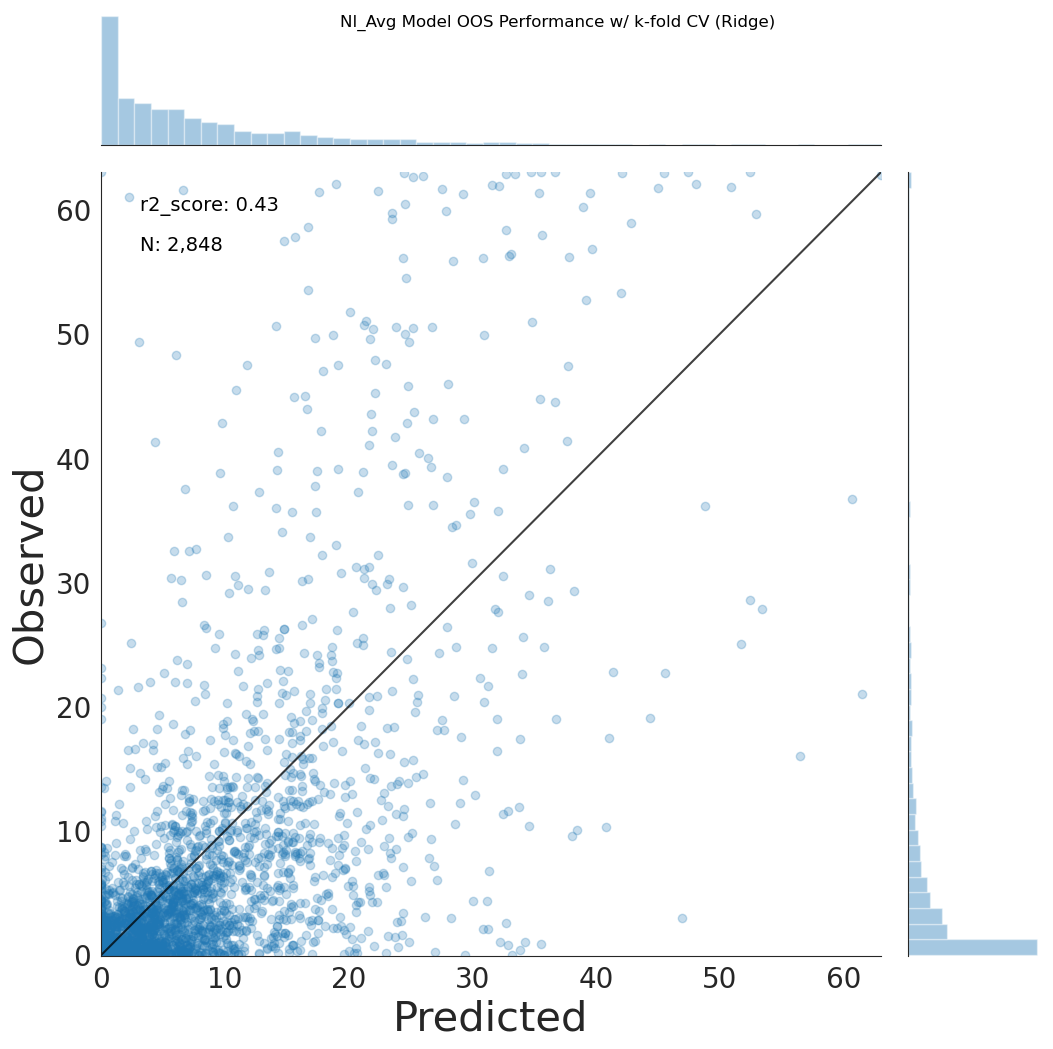

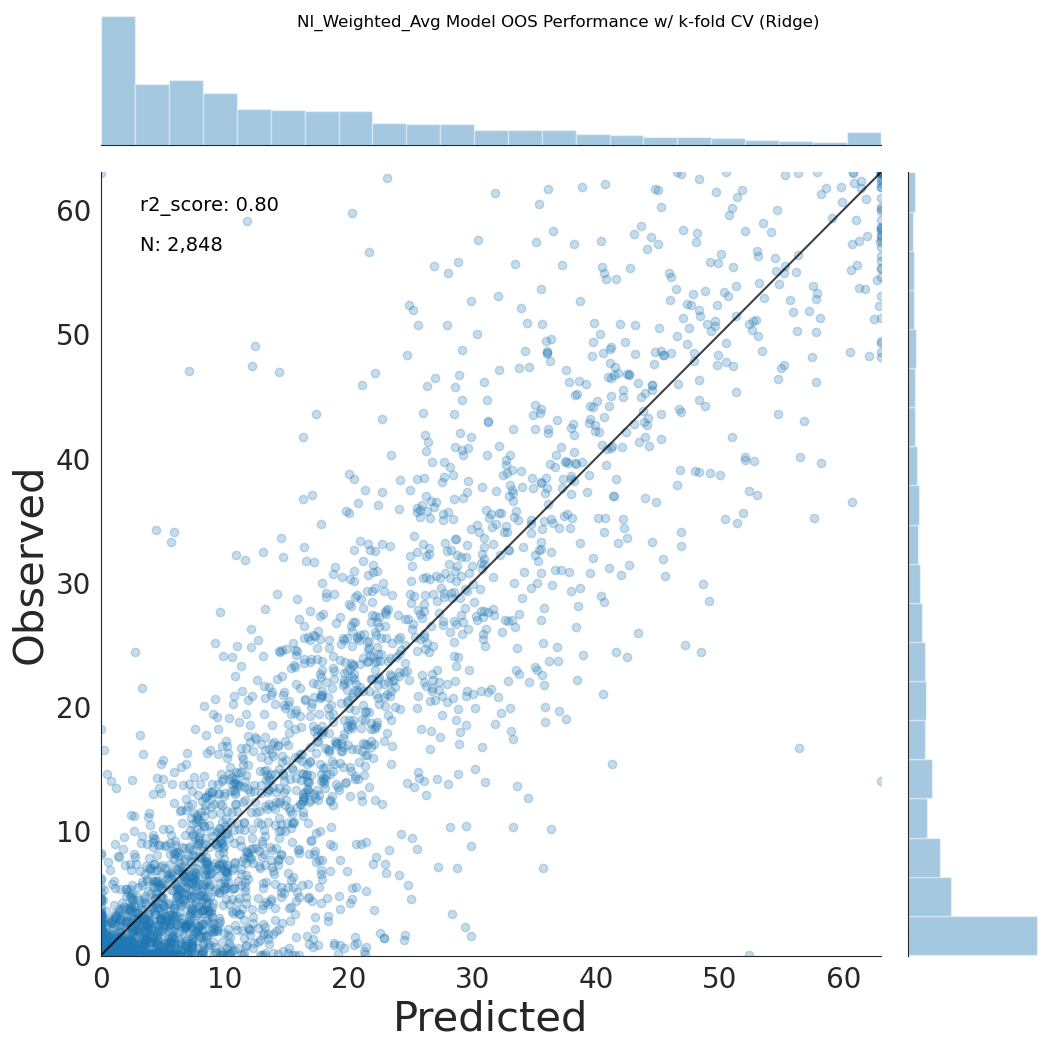

In [33]:
adm1_kfold_dict = {}

for task in tasks:
    y = y_df[task].astype(float)
    
    adm1_kfold_dict[task] = cv_solve(task, 
                             X,
                            y,
                                 solver_kwargs = solver_kwargs,
                             clip_bounds = [np.min(y), np.max(y)],
                                     country_fold=True
                            )

In [34]:
outpath = (data_dir + "model_data/dmsp_nl_model_adm1_model.pkl")
pickle.dump(adm1_kfold_dict, open(outpath, "wb"))

adm1_kfold_dict = pickle.load(open(outpath, "rb"))


In [35]:
n_train_adm1 = len(y_adm1)

### Evaluate at ADM1 level (within CV folds)

In [36]:
adm1_to_adm1_perf_dict = {}

for task in tasks:

    truth, preds = get_truth_preds_from_kfold_results(adm1_kfold_dict[task])
    
    locs = np.hstack(adm1_kfold_dict[task]["locations_test"])
    truth = pd.Series(truth.flatten(), index =locs)
    preds = pd.Series(preds.flatten(), index =locs)
    
    adm1_to_adm1_perf_dict[task] = nl_pred_truth_to_metrics_at_ADM1(preds,truth, task)
    
    

### Evlauate at ADM2 level (no longer evaluating within CV folds)


In [37]:
adm1_to_adm2_perf_dict = {}

for task in tasks:

    preds = predict_y_from_kfold_dict(X_adm2, adm1_kfold_dict, task)
    truth = y_adm2[task]
    
    adm1_to_adm2_perf_dict[task] = nl_pred_truth_to_metrics_at_ADM2(preds, truth, task, drop_ireland=drop_ireland)

r2 =  0.36130875370615234
r2 =  0.7635951740626167


In [38]:
n_eval_adm2 = len(preds)
if drop_ireland:
    n_eval_adm2 = (~preds.index.str.startswith("IRL")).sum()

## Now we just repeat for the ADM1 demeaned by ADM0 model

In [39]:
y_df = y_adm1_demeaned

X = X_adm1_demeaned

In [40]:
n_train_demean = len(y_adm1_demeaned)

### Run Model

nl_avg
Training model...

on fold (of 5): 0 1 2 3 4 



/home/lsherman/miniconda3/envs/hdi/lib/python3.7/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


Plotting nl_avg...
nl_weighted_avg
Training model...

on fold (of 5): 0 1 2 3 4 



/home/lsherman/miniconda3/envs/hdi/lib/python3.7/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


Plotting nl_weighted_avg...


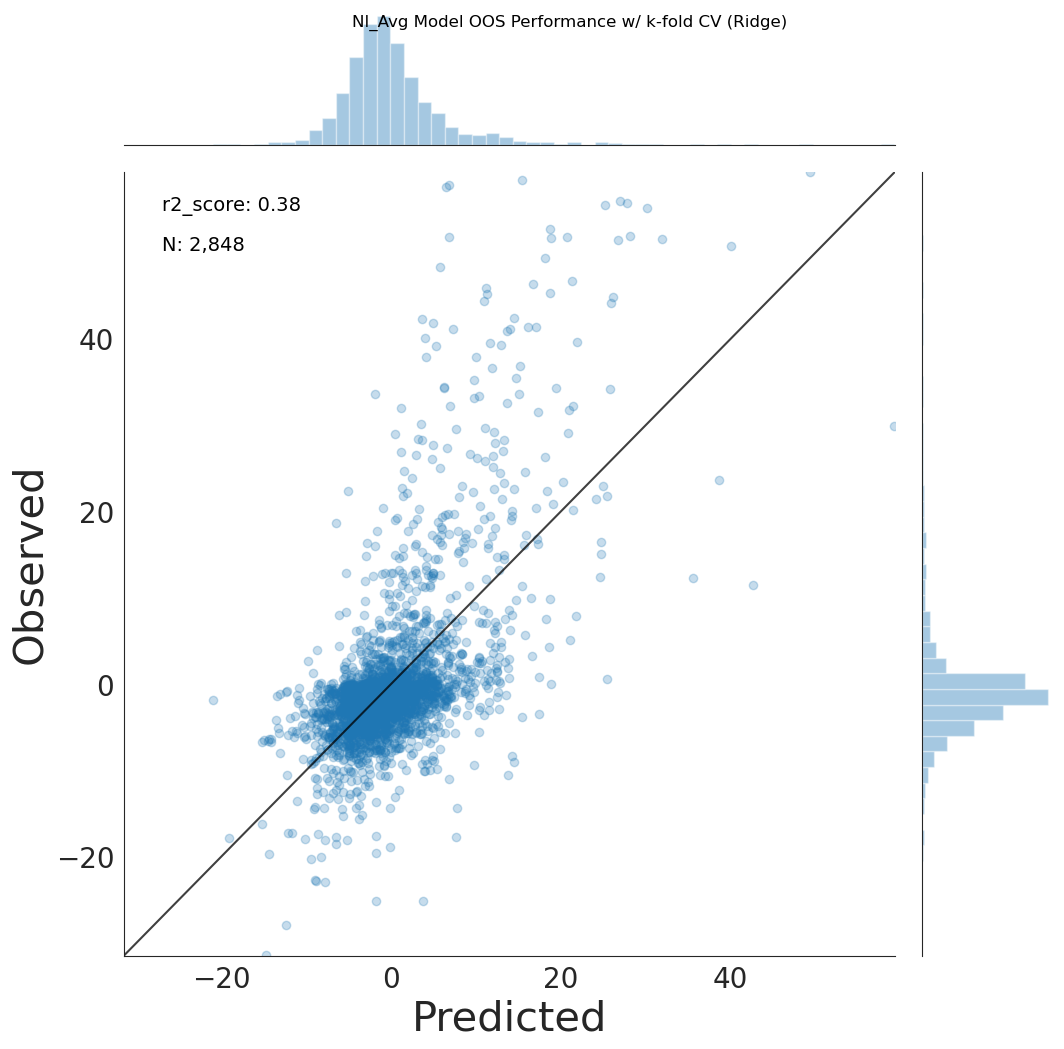

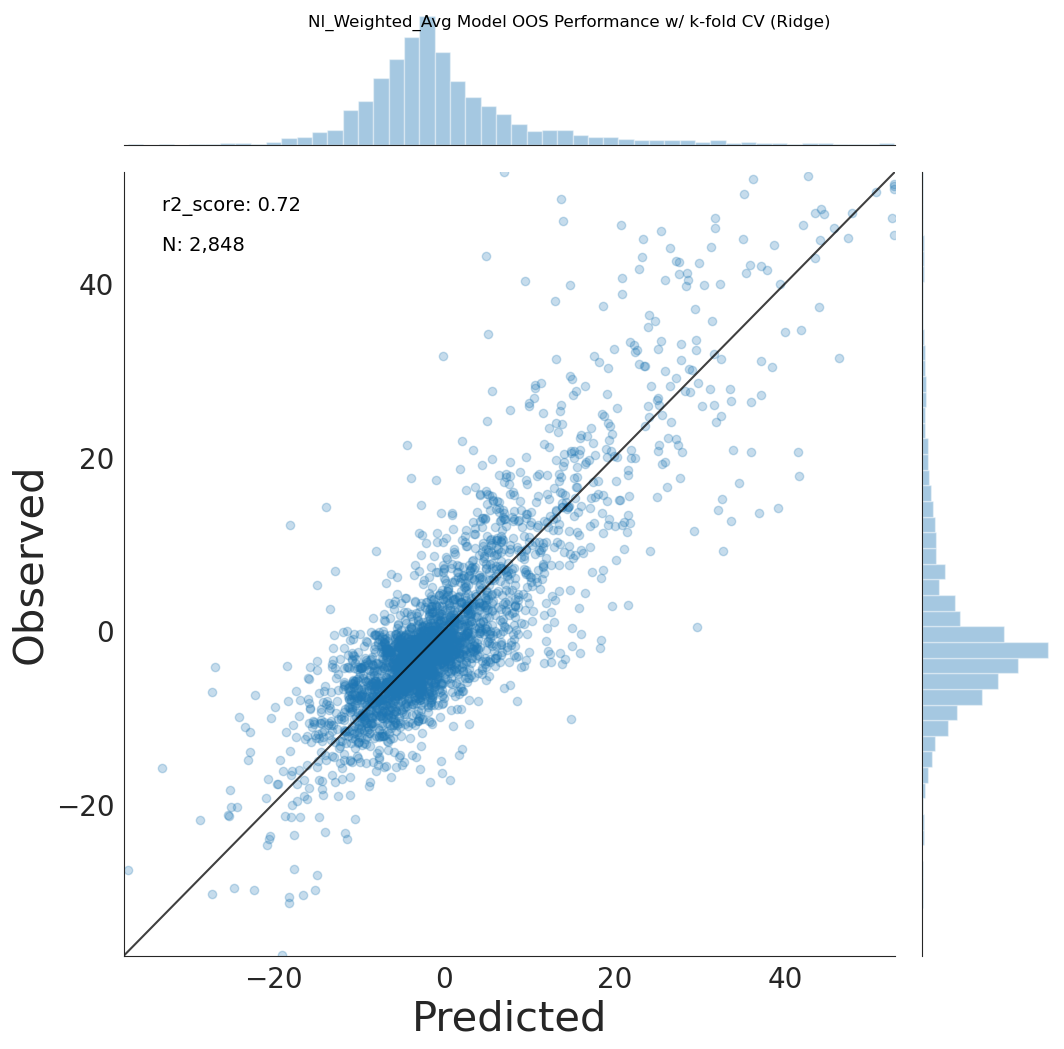

In [41]:
demeaned_adm1_kfold_dict = {}

for task in tasks:
    y = y_df[task].astype(float)
    
    demeaned_adm1_kfold_dict[task] = cv_solve(task, 
                             X,
                            y,
                                 solver_kwargs = solver_kwargs,
                             clip_bounds = [np.min(y), np.max(y)],
                                     country_fold=True
                            )

In [42]:
outpath = (data_dir + "model_data/dmsp_nl_model_adm1_demeaned_by_adm0_model.p")
pickle.dump(demeaned_adm1_kfold_dict, open(outpath, "wb"))

demeaned_adm1_kfold_dict = pickle.load(open(outpath, "rb"))


### Evaluate at ADM1 level (within CV folds)

In [43]:
demeaned_adm1_to_adm1_perf_dict = {}

for task in tasks:

    truth, preds = get_truth_preds_from_kfold_results(demeaned_adm1_kfold_dict[task])
    
    locs = np.hstack(demeaned_adm1_kfold_dict[task]["locations_test"])
    truth = pd.Series(truth.flatten(), index =locs)
    preds = pd.Series(preds.flatten(), index =locs)
    
    demeaned_adm1_to_adm1_perf_dict[task] = nl_pred_truth_to_metrics_at_ADM1(preds,truth, task, 
                                                                             demeaned_input=True, 
                                                                            return_df=False)
    

### Evaluate at ADM2 level (no longer within CV folds)

In [44]:
demean_adm1_to_adm2_perf_dict = {}

for task in tasks:

    preds = predict_y_from_kfold_dict(X_adm2_demeaned,demeaned_adm1_kfold_dict,task,)
    truth = y_adm2_demeaned[task]
    
    demean_adm1_to_adm2_perf_dict[task] = nl_pred_truth_to_metrics_at_ADM2(preds, truth, task, demeaned_input=True, recenter_on=recenter_on, drop_ireland=drop_ireland,
                                                                         adm0_unweighted_from_adm1_obs=y_adm0_not_weighted, extra_clip=extra_clip,
                                                                          )

Clipping changes:  40.94060980597083 % of obs
Clipping too high:  0.06179851865315582 % of obs
Clipping too low:  40.878811287317674 % of obs
r2 =  0.3126897346565555
Clipping changes:  19.53560230835643 % of obs
Clipping too high:  3.003589766892352 % of obs
Clipping too low:  16.53201254146408 % of obs
r2 =  0.7801980308720783


In [45]:
task = tasks[1] #pop weighted

pred_directory = data_dir + "preds/"
file = pred_directory + f"nl_adm2_preds_recenter={recenter_on}_dropIreland={drop_ireland}_extra_clip={extra_clip}"

df = nl_pred_truth_to_metrics_at_ADM2(preds, truth, task, demeaned_input=True, recenter_on=recenter_on, drop_ireland=drop_ireland, return_df=True,
                                                                         adm0_unweighted_from_adm1_obs=y_adm0_not_weighted, extra_clip=extra_clip,                                                                    )
df.to_pickle(file)


Clipping changes:  19.53560230835643 % of obs
Clipping too high:  3.003589766892352 % of obs
Clipping too low:  16.53201254146408 % of obs
r2 =  0.7801980308720783


In [46]:
### Visualize

In [47]:
# df = nl_pred_truth_to_metrics_at_ADM2(preds, truth, tasks[0], demeaned_input=True, extra_clip=True, recenter_on="adm1",
#                                                                          adm0_unweighted_from_adm1_obs=y_adm0_not_weighted,
#                                                                           return_df=True, drop_ireland=True)
# make_scatterplot("Demean by ADM1 scatter",df["true_demean_adm1"], df["preds_demean_adm1"])

In [48]:
# df = nl_pred_truth_to_metrics_at_ADM2(preds, truth, tasks[1], demeaned_input=True, extra_clip=False, recenter_on="adm1",
#                                                                          adm0_unweighted_from_adm1_obs=y_adm0_not_weighted,
#                                                                           return_df=True, drop_ireland=False)
# make_scatterplot("Demean by ADM1 scatter",df["true_demean_adm1"], df["preds_demean_adm1"])

## Make table for NL

In [49]:
rename_dict = {"pearson": "$\rho^{2}$", "spearman":"Spearman r", "r2":"$R^{2}$",
               "within_adm0_pearson": "$\rho^{2}$", "within_adm0_spearman":"Spearman r", "within_adm0_r2":"$R^{2}$",
               "within_adm1_pearson": "$\rho^{2}$", "within_adm1_spearman":"Spearman r", "within_adm1_r2":"$R^{2}$",
    
}

In [50]:
def make_table(task, level="adm2"):
    outcomes_dicts =[

    adm0_to_adm1_perf_dict,
    adm1_to_adm1_perf_dict,
    demeaned_adm1_to_adm1_perf_dict ,

    ]


    outcomes = [outcome[task] for outcome in outcomes_dicts]

    table = pd.DataFrame(outcomes)

    outcomes_dicts2 =[

    adm0_to_adm2_perf_dict,
    adm1_to_adm2_perf_dict,
    demean_adm1_to_adm2_perf_dict ,

    ]


    outcomes = [outcome[task] for outcome in outcomes_dicts2]


    table  = pd.concat([table,pd.DataFrame(outcomes)],axis=1)



    table = table.round(2)

    table[table < 0] = "$< 0$"


    table = table.rename(columns = rename_dict)


    table.loc[0,"NL"] = "\textbf{Country level} " +f"(n={n_train_adm0})"
    table.loc[1,"NL"] = "\textbf{Province level} " +  "(n={:,})".format(n_train_adm1)
    table.loc[2,"NL"] = "\textbf{Within-country} "+  "(n={:,})".format(n_train_demean)


    table[""] = "MOSAIKS"

    table.loc[3] = "\textbf{Predicted at ADM1 level} " +  "(n={:,})".format(n_eval_adm1)
    table.iloc[3,6:] = "\textbf{Predicted at ADM2 level} " +  "(n={:,})".format(n_eval_adm2)

    table.loc[4] ="\emph{ADM1 performance}"
    table.iloc[4,3:6] = "\emph{Within-country performance}"
    table.iloc[4,6:9] = "\emph{ADM2 performance}"
    table.iloc[4,9:12] = "\emph{Within-country performance}"
    table.iloc[4,12:15] = "\emph{Within-province performance}"
    
    if level == "adm2":
        table = table.iloc[:,[6,8,9,11,12,14,15,16]]
    elif level == "adm1":
        table = table.iloc[:,[0,2,3,5,15,16]]
    else: 
        return table

    table.loc[5] = ("(" + pd.Series(np.arange(1,table.shape[1]+1)).astype(str) +")").to_numpy()

    table = table.T.reset_index().set_index([3,4,"index",5])

    tab = table.T

    tab.columns.names = ([None, None, None,None])


    table = tab.set_index([tab.columns[-2],tab.columns[-1]])


    table.index.names = ["\textbf{ \emph{NL trained at}}", "\textbf{ \emph{Features}}"]

    table = table.iloc[[2,1,0]]

    return table


In [51]:
table = make_table(tasks[1])


print(table.to_latex(bold_rows=False,column_format="ll||cc|cc|cc",
     escape=False, multicolumn_format="c")  )

table

\begin{tabular}{ll||cc|cc|cc}
\toprule
                               &         & \multicolumn{6}{c}{\textbf{Predicted at ADM2 level} (n=62,487)} \\
                               &         & \multicolumn{2}{c}{\emph{ADM2 performance}} & \multicolumn{2}{c}{\emph{Within-country performance}} & \multicolumn{2}{c}{\emph{Within-province performance}} \\
                               &         &                                  $\rho^{2}$ & $R^{2}$ &                        $\rho^{2}$ & $R^{2}$ &                         $\rho^{2}$ & $R^{2}$ \\
                               &         &                                         (1) &     (2) &                               (3) &     (4) &                                (5) &     (6) \\
\textbf{ \emph{NL trained at}} & \textbf{ \emph{Features}} &                                             &         &                                   &         &                                    &         \\
\midrule
\textbf{Within-country} (n=2,848) & MOSAIK

\textbf{Predicted at ADM2 level} (n=62,487)  \
                                                                                \emph{ADM2 performance}   
                                                                                             $\rho^{2}$   
                                                                                                    (1)   
\textbf{ \emph{NL trained at}}    \textbf{ \emph{Features}}                                               
\textbf{Within-country} (n=2,848) MOSAIKS                                                          0.79   
\textbf{Province level} (n=2,848) MOSAIKS                                                          0.76   
\textbf{Country level} (n=170)    MOSAIKS                                                           0.6   

                                                                     \
                                                                      
                                                            $R^{2}$   
                                                                (2)   
\textbf{ \emph{NL trained at}}    \textbf{ \emph{Features}}           
\textbf{Within-country} (n=2,848) MOSAIKS                      0.78   
\textbf{Province level} (n=2,848) MOSAIKS                      0.76   
\textbf{Country level} (n=170)    MOSAIKS                      0.58   

                                                                                               \
                                                            \emph{Within-country performance}   
                                                                                   $\rho^{2}$   
                                                                                          (3)   
\textbf{ \emph{NL trained at}}    \textbf{ \emph{Features}}                                     
\textbf{Within-country} (n=2,848) MOSAIKS                                                0.66   
\textbf{Province level} (n=2,848) MOSAIKS                                                0.63   
\textbf{Country level} (n=170)    MOSAIKS                                                0.44   

                                                                     \
                                                                      
                                                            $R^{2}$   
                                                                (4)   
\textbf{ \emph{NL trained at}}    \textbf{ \emph{Features}}           
\textbf{Within-country} (n=2,848) MOSAIKS                      0.65   
\textbf{Province level} (n=2,848) MOSAIKS                      0.61   
\textbf{Country level} (n=170)    MOSAIKS                      0.38   

                                                                                                \
                                                            \emph{Within-province performance}   
                                                                                    $\rho^{2}$   
                                                                                           (5)   
\textbf{ \emph{NL trained at}}    \textbf{ \emph{Features}}                                      
\textbf{Within-country} (n=2,848) MOSAIKS                                                 0.61   
\textbf{Province level} (n=2,848) MOSAIKS                                                 0.58   
\textbf{Country level} (n=170)    MOSAIKS                                                  0.4   

                                                                     
                                                                     
                                                            $R^{2}$  
                                                                (6)  
\textbf{ \emph{NL trained at}}    \textbf{ \emph{Features}}          
\textbf{Within-country} (n=2,848) MOSAIKS                      0.59  
\textbf{Province level} (n=2,848) MOSAIKS                      0.55  
\textbf{Count

In [52]:
table = make_table(tasks[1], level="adm1")


print(table.to_latex(bold_rows=False,column_format="ll||cc|cc|cc",
     escape=False, multicolumn_format="c")  )

table

\begin{tabular}{ll||cc|cc|cc}
\toprule
                               &         & \multicolumn{4}{c}{\textbf{Predicted at ADM1 level} (n=2,848)} \\
                               &         & \multicolumn{2}{c}{\emph{ADM1 performance}} & \multicolumn{2}{c}{\emph{Within-country performance}} \\
                               &         &                                 $\rho^{2}$ & $R^{2}$ &                        $\rho^{2}$ & $R^{2}$ \\
                               &         &                                        (1) &     (2) &                               (3) &     (4) \\
\textbf{ \emph{NL trained at}} & \textbf{ \emph{Features}} &                                            &         &                                   &         \\
\midrule
\textbf{Within-country} (n=2,848) & MOSAIKS &                                       0.89 &    0.89 &                              0.76 &    0.76 \\
\textbf{Province level} (n=2,848) & MOSAIKS &                                        0.8 &     0

\textbf{Predicted at ADM1 level} (n=2,848)  \
                                                                               \emph{ADM1 performance}   
                                                                                            $\rho^{2}$   
                                                                                                   (1)   
\textbf{ \emph{NL trained at}}    \textbf{ \emph{Features}}                                              
\textbf{Within-country} (n=2,848) MOSAIKS                                                         0.89   
\textbf{Province level} (n=2,848) MOSAIKS                                                          0.8   
\textbf{Country level} (n=170)    MOSAIKS                                                         0.69   

                                                                     \
                                                                      
                                                            $R^{2}$   
                                                                (2)   
\textbf{ \emph{NL trained at}}    \textbf{ \emph{Features}}           
\textbf{Within-country} (n=2,848) MOSAIKS                      0.89   
\textbf{Province level} (n=2,848) MOSAIKS                       0.8   
\textbf{Country level} (n=170)    MOSAIKS                      0.67   

                                                                                               \
                                                            \emph{Within-country performance}   
                                                                                   $\rho^{2}$   
                                                                                          (3)   
\textbf{ \emph{NL trained at}}    \textbf{ \emph{Features}}                                     
\textbf{Within-country} (n=2,848) MOSAIKS                                                0.76   
\textbf{Province level} (n=2,848) MOSAIKS                                                0.71   
\textbf{Country level} (n=170)    MOSAIKS                                                0.56   

                                                                     
                                                                     
                                                            $R^{2}$  
                                                                (4)  
\textbf{ \emph{NL trained at}}    \textbf{ \emph{Features}}          
\textbf{Within-country} (n=2,848) MOSAIKS                      0.76  
\textbf{Province level} (n=2,848) MOSAIKS                      0.71  
\textbf{Country level} (n=170)    MOSAIKS                      0.54

In [56]:
#Uncomment to see results for non-pop weighted NL

#make_table(tasks[0])